In [1]:
import pandas as pd
import numpy as np

import pathlib
import json
import glob

from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr

import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
pair_predictions = ['mrpc','qnli','qqp','rte','stsb',]
fact_predictions = [f"fact_{p_p}" for p_p in pair_predictions]
single_predictions = ['cola', 'sst']
all_scores = single_predictions + pair_predictions + fact_predictions
criteria_names = ['Understandable', 'Natural', 'Maintains Context', 'Engaging', 'Uses Knowledge', 'Overall']

In [3]:
with open("../data/eval_usr_percona_chat.json", "rt") as fin:
    dialogue_data = json.load(fin)
    
dialogue_data_df = list()

for dialogue in dialogue_data:
    for response in dialogue["responses"]:
        row = dict(response)
        
        for criterium in criteria_names:
            row[criterium] = np.average(row[criterium])
        
        row.pop("response", None)
        row.pop("model", None)
        
        dialogue_data_df.append(row)
        
dialogue_data_df = pd.DataFrame(dialogue_data_df)
dialogue_data_df.shape

(300, 18)

In [4]:
dialogue_data_df.head(1)

,Understandable,Natural,Maintains Context,Engaging,Uses Knowledge,Overall,cola,sst,mrpc,fact_mrpc,qqp,fact_qqp,stsb,fact_stsb,qnli,fact_qnli,rte,fact_rte
0,1.0,3.0,3.0,1.333333,0.0,3.666667,0.628361,0.123976,0.165805,0.109548,0.000108,0.000088,1.201328,0.579063,0.041934,0.398787,0.097636,0.947536


In [5]:
for column in (criteria_names + all_scores):
    dialogue_data_df[column] = minmax_scale(dialogue_data_df[column])

In [6]:
lin_model = LinearRegression(fit_intercept=True).fit(
    X=dialogue_data_df[pair_predictions].to_numpy(),
    y=dialogue_data_df["Overall"].to_numpy()
)
dialogue_data_df["lin-reg_pair"] = lin_model.predict(dialogue_data_df[pair_predictions].to_numpy())

pprint(list(zip(pair_predictions, lin_model.coef_)) + [lin_model.intercept_])

[('mrpc', 0.45147490627866715),
 ('qnli', -0.1469290258480331),
 ('qqp', -0.3615345399496674),
 ('rte', 0.16524145269323834),
 ('stsb', 0.4143835059107151),
 0.38886033611650206]


In [7]:
lin_model = LinearRegression(fit_intercept=True).fit(
    X=dialogue_data_df[fact_predictions].to_numpy(),
    y=dialogue_data_df["Overall"].to_numpy()
)
dialogue_data_df["lin-reg_fact"] = lin_model.predict(dialogue_data_df[fact_predictions].to_numpy())

pprint(list(zip(fact_predictions, lin_model.coef_)) + [lin_model.intercept_])

[('fact_mrpc', -0.09542596137493763),
 ('fact_qnli', -0.059350418415453896),
 ('fact_qqp', 0.029504507039982097),
 ('fact_rte', 0.12499483475104593),
 ('fact_stsb', 0.5539559369418295),
 0.43540192831134983]


In [8]:
lin_model = LinearRegression(fit_intercept=True).fit(
    X=dialogue_data_df[single_predictions].to_numpy(),
    y=dialogue_data_df["Overall"].to_numpy()
)
dialogue_data_df["lin-reg_single"] = lin_model.predict(dialogue_data_df[single_predictions].to_numpy())

pprint(list(zip(single_predictions, lin_model.coef_)) + [lin_model.intercept_])

[('cola', -0.03490555282150484),
 ('sst', 0.08252830901421308),
 0.6326823116867405]


In [9]:
lin_model = LinearRegression(fit_intercept=True).fit(
    X=dialogue_data_df[all_scores].to_numpy(),
    y=dialogue_data_df["Overall"].to_numpy()
)
dialogue_data_df["lin-reg_all"] = lin_model.predict(dialogue_data_df[all_scores].to_numpy())

pprint(list(zip(all_scores, lin_model.coef_)) + [lin_model.intercept_])

[('cola', 0.02937436650814499),
 ('sst', 0.028958854808668125),
 ('mrpc', 0.3248382017389009),
 ('qnli', -0.1268279865939197),
 ('qqp', -0.1365986166614643),
 ('rte', 0.12694834227819343),
 ('stsb', 0.36497287477086754),
 ('fact_mrpc', -0.10879131621483915),
 ('fact_qnli', 0.020632389125348347),
 ('fact_qqp', 0.06163486408383957),
 ('fact_rte', 0.06536950338969356),
 ('fact_stsb', 0.5113217853265033),
 0.16530204684730748]


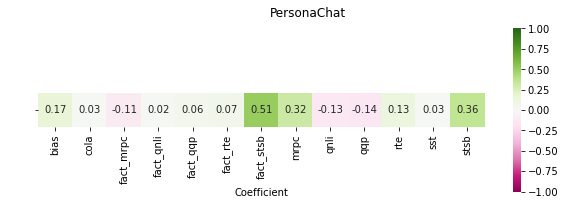

In [10]:
lin_model = LinearRegression(fit_intercept=True).fit(
    X=dialogue_data_df[all_scores].to_numpy(),
    y=dialogue_data_df["Overall"].to_numpy()
)
dialogue_data_df["lin-reg_all"] = lin_model.predict(dialogue_data_df[all_scores].to_numpy())

lr_weights = [("bias", lin_model.intercept_)] + list(zip(all_scores, lin_model.coef_))
lr_weights = pd.DataFrame(lr_weights, columns=["Coefficient", "value"])
lr_weights["\u2800"] = len(lr_weights) * ["\u2800"]
lr_weights["value"] = lr_weights["value"].round(2)

g, ax = plt.subplots(figsize=(10, 3))
sns.heatmap(
    lr_weights.pivot("\u2800", "Coefficient", "value"),
    center=0, vmin=-1, vmax=1,
    annot=True,
    cmap="PiYG",
    square=True,
)

pathlib.Path('../data/plots').mkdir(parents=True, exist_ok=True)
g.suptitle('PersonaChat')
g.savefig("../data/plots/persona_lin-reg_weights.png")
g.savefig("../data/plots/persona_lin-reg_weights.svg")

In [11]:
lin_reg_cols = [f"lin-reg_{component}" for component in ("pair", "fact", "single", "all")]

In [12]:
for pred in (all_scores + lin_reg_cols):
    print(f"<<<<<{pred}>>>>>")
    for evaluation in criteria_names:
        x = dialogue_data_df[pred]
        y =  dialogue_data_df[evaluation]
        pears = pearsonr(x, y)
        pears = tuple(round(x,4) for x in pears)
        print(f'{pred}-{evaluation}_pearson: \t{pears}')
        spears = spearmanr(x, y)
        spears = tuple(round(x,4) for x in spears)
        print(f'{pred}-{evaluation}_spearman: \t{spears}')
    print(f"<<<<<{pred}>>>>>")

<<<<<cola>>>>>
cola-Understandable_pearson: 	(0.0318, 0.5828)
cola-Understandable_spearman: 	(0.0673, 0.2451)
cola-Natural_pearson: 	(0.0838, 0.1475)
cola-Natural_spearman: 	(-0.0309, 0.5945)
cola-Maintains Context_pearson: 	(-0.0862, 0.1365)
cola-Maintains Context_spearman: 	(-0.1935, 0.0008)
cola-Engaging_pearson: 	(-0.0665, 0.251)
cola-Engaging_spearman: 	(-0.1568, 0.0065)
cola-Uses Knowledge_pearson: 	(-0.019, 0.7425)
cola-Uses Knowledge_spearman: 	(-0.1403, 0.015)
cola-Overall_pearson: 	(-0.0252, 0.6635)
cola-Overall_spearman: 	(-0.1931, 0.0008)
<<<<<cola>>>>>
<<<<<sst>>>>>
sst-Understandable_pearson: 	(0.0743, 0.1996)
sst-Understandable_spearman: 	(0.0723, 0.2119)
sst-Natural_pearson: 	(-0.0064, 0.9119)
sst-Natural_spearman: 	(0.0294, 0.6123)
sst-Maintains Context_pearson: 	(0.076, 0.189)
sst-Maintains Context_spearman: 	(0.0988, 0.0875)
sst-Engaging_pearson: 	(0.153, 0.008)
sst-Engaging_spearman: 	(0.1242, 0.0315)
sst-Uses Knowledge_pearson: 	(0.0422, 0.4663)
sst-Uses Knowledge_

/home/rosko/miniconda3/envs/proxy_indicators/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/rosko/miniconda3/envs/proxy_indicators/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


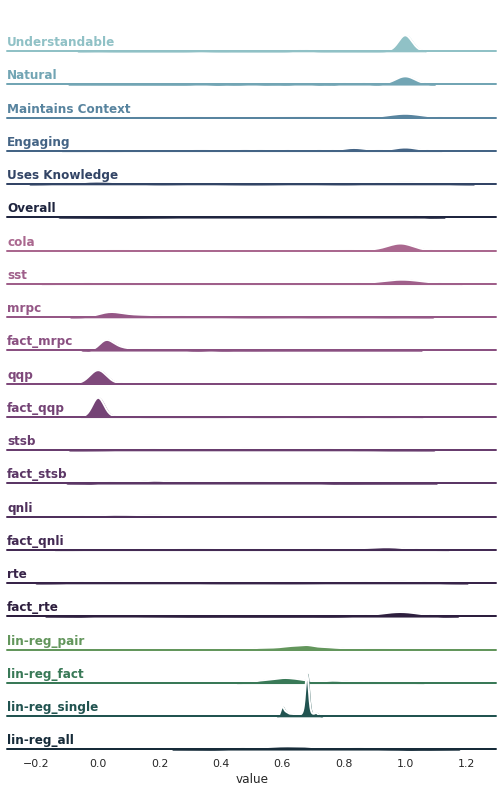

In [13]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = pd.melt(dialogue_data_df)

# Initialize the FacetGrid object
a = sns.cubehelix_palette(len(criteria_names), rot=-0.25, light=0.7)
b = sns.cubehelix_palette(len(single_predictions + pair_predictions + fact_predictions), light=0.5)
c = sns.cubehelix_palette(len(lin_reg_cols), rot=-0.75, light=0.5)
g = sns.FacetGrid(df, row="variable", hue="variable", aspect=15, height=.5, palette=a+b+c)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [14]:
score_df = list()

for pred in (all_scores + lin_reg_cols):
    for evaluation in criteria_names:
        x = dialogue_data_df[pred]
        y =  dialogue_data_df[evaluation]
        pears = pearsonr(x, y)
        pears = tuple(round(x,4) for x in pears)
        spears = spearmanr(x, y)
        spears = tuple(round(x,4) for x in spears)
        
        score_df.append({
            "eval": f"{pred}-{evaluation}",
            "pears":pears[0],
            "pears_p":pears[1],
            "spear":spears[0],
            "spear_p":spears[1],
        })
        
score_df = pd.DataFrame(score_df)

In [15]:
score_df.to_csv("../data/persona_scores.csv", index=False)

In [16]:
plot_df = dialogue_data_df.melt(value_vars=criteria_names, id_vars=all_scores + lin_reg_cols)
plot_df = plot_df.rename(columns={"variable": "criteria", "value": "criteria_value"})
plot_df = plot_df.melt(value_vars=all_scores + lin_reg_cols, id_vars =["criteria_value", "criteria"])
plot_df = plot_df.rename(columns={"variable": "prediction", "value": "prediction_value"})
plot_df.head()

,criteria_value,criteria,prediction,prediction_value
0,1.000000,Understandable,cola,0.619507
1,1.000000,Understandable,cola,0.329002
2,1.000000,Understandable,cola,0.933082
3,0.333333,Understandable,cola,0.995669
4,1.000000,Understandable,cola,0.974474


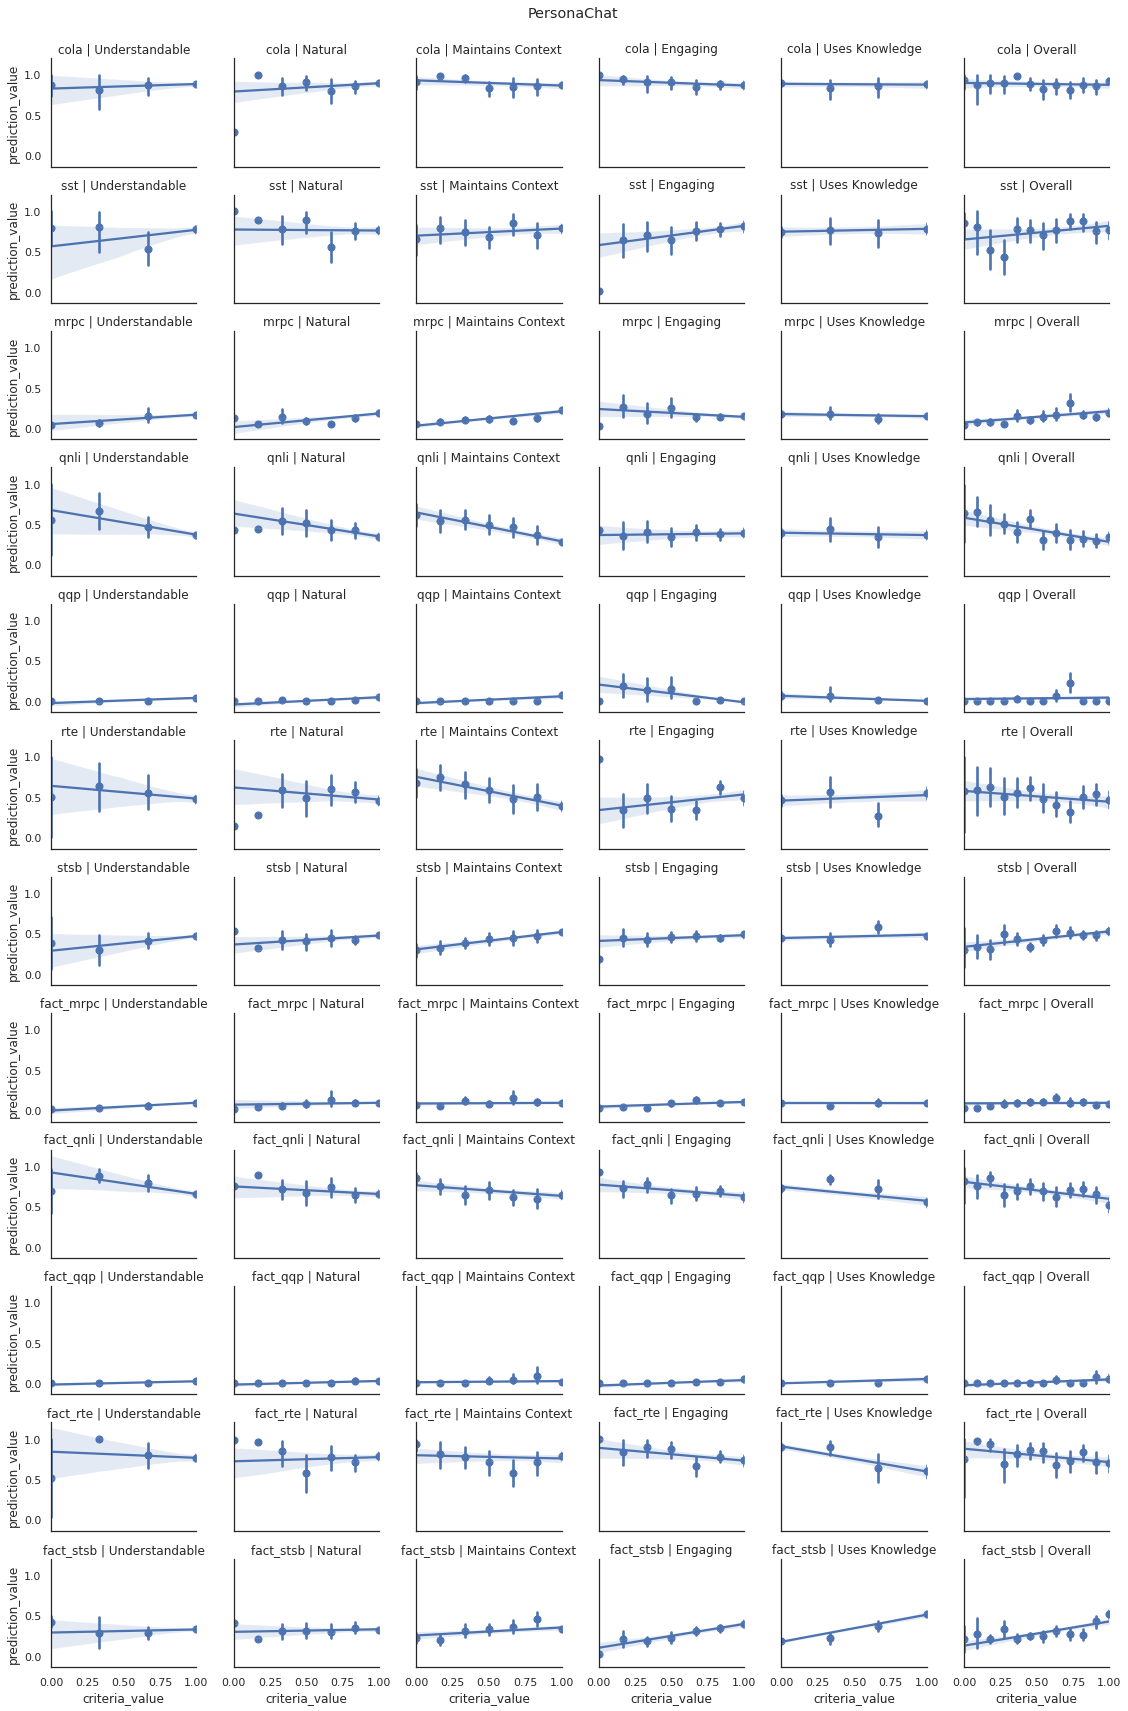

In [17]:
g = sns.lmplot(
    x="criteria_value", y="prediction_value",
    col="criteria", row="prediction",
    sharex=True, sharey=True,
    data=plot_df[plot_df["prediction"].isin(all_scores)],
    height=2, aspect=1.3,
    x_estimator=np.mean,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('PersonaChat')
g.savefig("../data/plots/persona_glue_reg_plot.png")
g.savefig("../data/plots/persona_glue_reg_plot.svg")

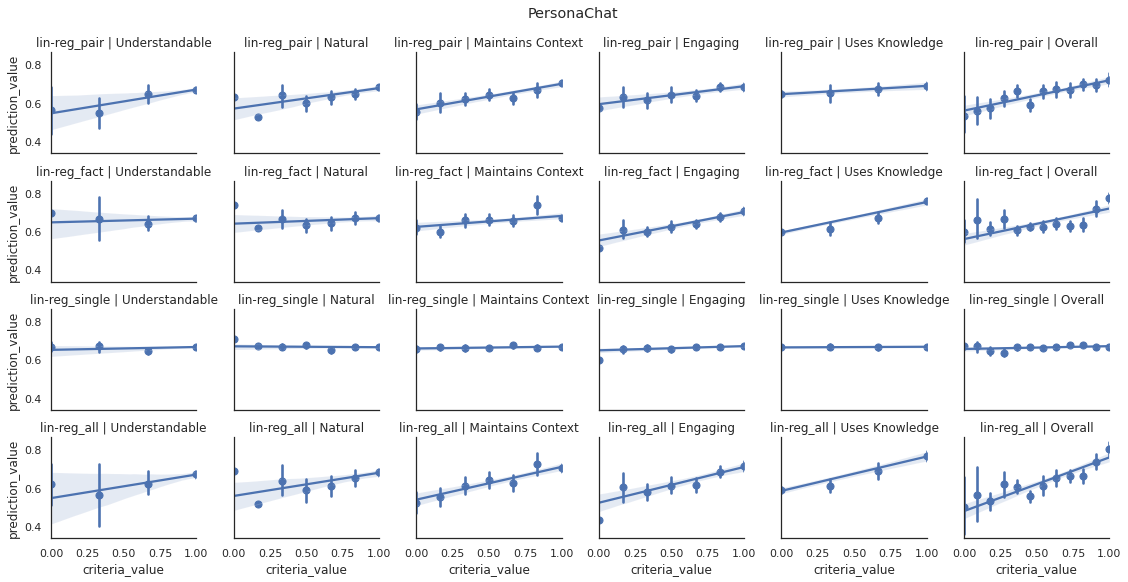

In [18]:
g = sns.lmplot(
    x="criteria_value", y="prediction_value",
    col="criteria", row="prediction",
    sharex=True, sharey=True,
    data=plot_df[plot_df["prediction"].isin(lin_reg_cols)],
    height=2, aspect=1.3,
    x_estimator=np.mean,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('PersonaChat')
g.savefig("../data/plots/persona_lin-reg_reg_plot.png")
g.savefig("../data/plots/persona_lin-reg_reg_plot.svg")